# Project D12
## ADL1 - Cleaning Data

### Authors:

#### Krister Kansi, Evaldas Petnjunas

##### Opening the datasets 

In [1]:
import pandas as pd
import numpy as np
positions = pd.read_table("data/out.csv",sep = ",")
autonomy = pd.read_table("data/out_autonomy.csv",sep = ",")
speed = pd.read_table("data/out_speed.csv",sep = ",")
steer = pd.read_table("data/out_steer.csv",sep = ",")
turn = pd.read_csv("data/outturn.csv",sep = ",")

#### Original Data

The data itself is located in ROS bag file, thus meaning it needed to be extracted. The ROS bag file also contains data 
that is irrelevant to the project, which implies that only relevant data needed to be extracted. The ROS bags included lots 
of data of different parameters in the self driving car from the turn signal being activated to it's location in coordinates. 
The original dataset was around 100 GB and was located on a virtual machine which we could access remotely. Necessary 
software needed to be installed to extract the data

##### Convert data into pandas DataFrames

In [2]:
pos_df = pd.DataFrame(positions)
auto_df = pd.DataFrame(autonomy)
speed_df = pd.DataFrame(speed)
steer_df = pd.DataFrame(steer)
turn_df = pd.DataFrame(turn)

The data extraction from the virtual machine was done via the conda environment. In there the necessary data was found from the ROS bag and uploaded to a github repository as csv files. There on the data could be read into pandas dataframes in jupyter notebook.


##### Speed graph of the car according to the speed dataframe

Below is a small but illustrative plot of the speed that the car was traveling at throughout the testdrive according to the speed bag

<AxesSubplot:title={'center':'speed'}, xlabel='points', ylabel='velocity'>

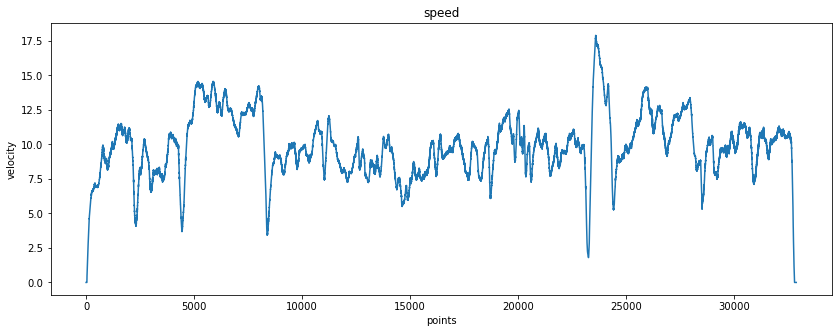

In [3]:
speed_df["field.vehicle_speed"].plot(figsize=(14,5), title="speed", xlabel="points", ylabel="velocity")

##### Finding the dataset with the best timestamp frequency

In [4]:
#pos_df: 20000003.229291935
#speed_df: 33486280.14943612
#steer_df: 33485068.742158055
#turn_df: 33486269.028086815
results = [20000003.229291935, 33486280.14943612, 33485068.742158055, 33486269.028086815]
print(min(results))

20000003.229291935


By looking at these two plots together we can basically imagine the direction the car was moving at a given time.

<AxesSubplot:>

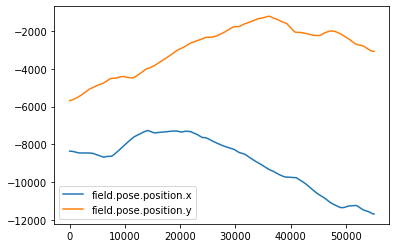

In [5]:
pos_df.plot(y=["field.pose.position.x", "field.pose.position.y"])

##### Deleting the beginning of the recording

In [6]:
def deletebeginning(pos_df):
    start_x = pos_df["field.pose.position.x"][0].round()#fixing the starting values
    print(start_x)
    start_y = pos_df["field.pose.position.y"][0].round()
    print(start_y)
    move_start_x=0#counters 
    move_start_y=0
    moved_x= False#value to represent whether the car has moved
    moved_y= False
    moved_index= 0#index counter
    for i in range(len(pos_df)):
        current_x=pos_df["field.pose.position.x"][i].round()#fixing the current x and y values
        current_y=pos_df["field.pose.position.y"][i].round()
        if current_x == start_x:# if the values do not change, they must be deleted
            move_start_x += 1
        else:
            moved_x= True
        if current_y == start_y:
            move_start_y += 1
        else:
            moved_y= True
            
        if moved_x and moved_y:# if the x and y values did change
            if move_start_x > move_start_y:#finding out which value changed last
                moved_index= move_start_x
            elif move_start_x < move_start_y:
                moved_index= move_start_y
    removable_indicies = pos_df[:moved_index]
    for index in range(len(removable_indicies)):
        remove_closest_time(speed_df, pos_df, index)
        remove_closest_time(steer_df, pos_df, index)
        remove_closest_time(turn_df, pos_df, index)
        pos_df.drop(index, 0, inplace=True)
        pos_df.reset_index(drop=True, inplace=True)
    print(moved_index)
    return pos_df

###### Deleting of the ending

In [7]:
def deleteend(pos_df):
    start_x = pos_df["field.pose.position.x"][len(pos_df["field.pose.position.x"])-1].round()
    start_y = pos_df["field.pose.position.y"][len(pos_df["field.pose.position.y"])-1].round()
    stop_start_x=0
    stop_start_y=0
    stopped_x= False
    stopped_y= False
    stopped_index= 0
    print(start_x)
    print(start_y)
    i = len(pos_df["field.pose.position.x"])-1
    while i > 0:
        current_x=pos_df["field.pose.position.x"][i].round()
        current_y=pos_df["field.pose.position.y"][i].round()
        if current_x == start_x:
            stop_start_x += 1
        else:
            stopped_x= True
        if current_y == start_y:
            stop_start_y += 1
        else:
            stopped_y= True
            
        if stopped_x and stopped_y:
            if stop_start_x > stop_start_y:
                stopped_index= stop_start_x
            elif stop_start_x < stop_start_y:
                stopped_index= stop_start_y
        i -= 1
    
    real_stopped_index = len(pos_df["field.pose.position.x"])-stopped_index
    removable_indicies = pos_df[real_stopped_index:]
    for index in range(len(pos_df["field.pose.position.x"])-1, real_stopped_index-1, -1):
        remove_closest_time(speed_df, pos_df, index)
        remove_closest_time(steer_df, pos_df, index)
        remove_closest_time(turn_df, pos_df, index)
        pos_df.drop(index, 0, inplace=True)
        pos_df.reset_index(drop=True, inplace=True)
        
    print(real_stopped_index)
    return pos_df

##### Method to delete all the necessary rows from all of the tables

In [8]:
def remove_closest_time(remove_table, origin_table, removed_index):
    #remove_table is the table from where we remove the row
    #origin_table is the table, where the original timestamp is
    #removed_index is the index in the origin table which timestamp we wish to compare
    closest = 10000000000000
    index = 0
    best_index = 0
    freq = 20000003.229291935 # best frequency across the tables from pos_df
    origin_table_time = origin_table["field.header.stamp"][removed_index] # time we wish to compare to other tables
    for time in remove_table["field.header.stamp"]:
        if abs(origin_table_time - time) < closest: # finding new best time compared to original
            closest = abs(origin_table_time - time)
            best_index = index
        index += 1
    if (closest / freq) < 1: # check to see whether the removable time seems valid or is unrelated.
        remove_table.drop(best_index, 0, inplace=True) # removes row
        remove_table.reset_index(drop=True, inplace=True) # resets indecies

##### Method to delete rows where the turn signal is active

In [9]:
def deleteturnsignalon():
    timestamptobedeleted = []
    for i in range(len(turn_df["field.enabled"])):
        if turn_df["field.enabled"][i] == 1:
            timestamptobedeleted.append(i)
    for index in timestamptobedeleted:
        remove_closest_time(pos_df,turn_df,index)
        remove_closest_time(speed_df,turn_df,index)
        remove_closest_time(steer_df,turn_df,index)
        turn_df.drop(index, 0, inplace=True)
        turn_df.reset_index(drop=True, inplace=True)

##### Method to delete rows where the car is reversing

##### This method was not needed as there was no reversing but it was still a task

In [10]:
def deletereversing(reversing_table): # reversing table is the table where the gear topic is in
    indicies_to_be_deleted = []
    for i in range(len(reversing_table["header.current_gear"])): # Finds all the rows where reverse is in
        if reversing_table["header.current_gear"] == 2:
            indicies_to_be_deleted.append(i)
    for index in indicies_to_be_deleted: # deletes all the corresponding rows from other files if they exist and from the current one
        remove_closest_time(pos_df,reversing_table,index)
        remove_closest_time(speed_df,reversing_table,index)
        remove_closest_time(steer_df,reversing_table,index)
        reversing_table.drop(index, 0, inplace=True)
        reversing_table.reset_index(drop=True, inplace=True)

##### Method to separate the curves from the straights

##### Two additional data frames to separate the curves from the straights

In [11]:
curves = pd.DataFrame(columns=["%time","field.header.seq","field.header.stamp","field.header.frame_id","field.pose.position.x","field.pose.position.y","field.pose.position.z","field.pose.orientation.x","field.pose.orientation.y","field.pose.orientation.z","field.pose.orientation.w"
])
straigths = pd.DataFrame(columns= ["%time","field.header.seq","field.header.stamp","field.header.frame_id","field.pose.position.x","field.pose.position.y","field.pose.position.z","field.pose.orientation.x","field.pose.orientation.y","field.pose.orientation.z","field.pose.orientation.w"
])

In [12]:
def separatecurves():
    turnvalue = 1
    curvelist = []
    templist = []
    for i in range(len(pos_df)):
        for j in range(len(turn_df)):
            if pos_df["field.header.stamp"][i] < turn_df["field.header.stamp"][j] or pos_df["field.header.stamp"][i] == turn_df["field.header.stamp"][j]:
                turnvalue = turn_df["field.output"][j]
                if turn_df["field.output"][j] == turnvalue and turnvalue != 1:
                    templist.append(i)
                    i += 1
        curvelist.append(templist)
        templist = []
    summ = 0
    for i in range(len(curvelist)):
        summ += len(curvelist[i])
    average = summ / len(curvelist)
    for i in range(len(pos_df)):
        for j in range(len(curvelist)):
            if len(curvelist[j]) >= average:
                for k in range(len(curvelist[j])):
                    curves.append(pos_df.curvelist[j].loc[k])
                    pos_df.drop(curvelist[j].loc[k], 0, inplace=True)
                    pos_df.reset_index(drop=True, inplace=True)
    for i in range(len(pos_df)):
        straigth.append(pos_df.loc[i])

In [13]:
pos_df = deletebeginning(pos_df)

-8354.0
-5678.0
111


In [14]:
pos_df = deleteend(pos_df)

-11672.0
-3078.0
54772


In [15]:
pos_df

,%time,field.header.seq,field.header.stamp,field.header.frame_id,field.pose.position.x,field.pose.position.y,field.pose.position.z,field.pose.orientation.x,field.pose.orientation.y,field.pose.orientation.z,field.pose.orientation.w
0,1635234546782376676,13641,1635234546781745556,map,-8354.300180,-5678.253026,65.867257,0.003351,-0.011833,0.833959,0.551689
1,1635234546822177181,13643,1635234546821535288,map,-8354.300188,-5678.252989,65.867358,0.003342,-0.011829,0.833960,0.551688
2,1635234546862063408,13645,1635234546861629707,map,-8354.300203,-5678.252961,65.867371,0.003336,-0.011836,0.833967,0.551678
3,1635234546903314414,13647,1635234546902683283,map,-8354.300230,-5678.252952,65.867383,0.003348,-0.011844,0.833964,0.551682
4,1635234546941999948,13649,1635234546941526382,map,-8354.300264,-5678.252964,65.867426,0.003344,-0.011842,0.833965,0.551680
...,...,...,...,...,...,...,...,...,...,...,...
54767,1635235644323060507,68518,1635235644321515155,map,-11670.575787,-3077.307902,82.851293,-0.013078,0.011809,0.977179,-0.211683
54768,1635235644342601887,68519,1635235644341446104,map,-11670.622551,-3077.329696,82.850943,-0.012979,0.011713,0.977196,-0.211618
54769,1635235644362599789,68520,1635235644361646792,map,-11670.668480,-3077.351145,82.850606,-0.012841,0.011554,0.977213,-0.211556
54770,1635235644382919547,68521,1635235644381533183,map,-11670.713768,-3077.372231,82.850281,-0.012706,0.011530,0.977230,-0.211488


##### Plot for showing the steering angle

In the plot below we could visually understand the path not by looking at the map but by inspecting the angle of the steering wheel.

<AxesSubplot:title={'center':'steering angle'}, xlabel='points', ylabel='angle'>

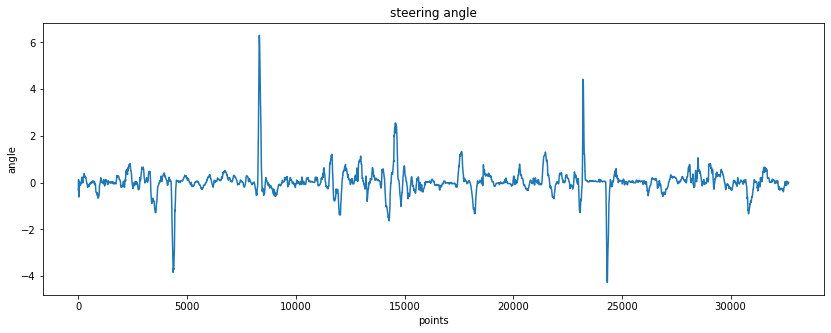

In [16]:
steer_df["field.output"].plot(figsize=(14,5), title="steering angle", xlabel="points", ylabel="angle")

##### Converting dataframes back to CSV files

In [18]:
pos_df.to_csv("out.csv")
speed_df.to_csv("out_speed.csv")
steer_df.to_csv("out_steer.csv")
turn_df.to_csv("outturn.csv")
curves.to_csv("curves.csv")
straigths.to_csv("straights.csv")

### Results

In the end we managed to complete the necesessary tasks and produced cleaner csv files from where machine learning algorithms should have an easier time learning from
Unfortunately our code only work with csv files with relatively same topics as inputs and does not work with ROS bags as an input